In [1]:
import cv2
import numpy as np
import random

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

SEED = 0

torch.manual_seed(SEED)
random.seed = SEED
np.random.seed = SEED

In [2]:
BASE_PATH = "data"
BATCH_SIZE = 64
N_CLASSES = 250

N_EPOCHS = 50
LR = 1e-3

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
print(torch.cuda.is_available())  # Should return True
print(torch.cuda.current_device())  # Returns the current device ID
print(torch.cuda.get_device_name(0))  # Returns the GPU name

True
0
NVIDIA GeForce RTX 2080 Ti


## Step 1: Data preprocessing

In [4]:
def show_img(img, title :str =None):
    # Convert the BGR image to RGB
    image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image using Matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off the axis
    plt.title(title)  # Optional: Set a title
    plt.show()

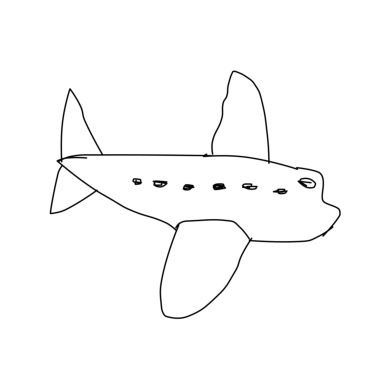

In [5]:
img = cv2.imread(BASE_PATH + "/airplane/1.png")
show_img(img)

In [6]:
import os
import pandas as pd

def load_image_dataset(root_dir=BASE_PATH):
    # Lists to store paths and classes
    image_paths = []
    class_names = []
    
    # Walk through all classes in the root directory
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Get all PNG files in the class directory
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.png'):
                    img_path = os.path.join(class_dir, img_name)
                    image_paths.append(img_path)
                    class_names.append(class_name)
    
    # Create DataFrame
    df = pd.DataFrame({
        'img_path': image_paths,
        'class_name': class_names
    })
    
    return df

# Usage
df = load_image_dataset()
print(df.head())

               img_path class_name
0   data/airplane/1.png   airplane
1  data/airplane/10.png   airplane
2  data/airplane/11.png   airplane
3  data/airplane/12.png   airplane
4  data/airplane/13.png   airplane


In [7]:
N_CLASSES = len(df.class_name.unique())

In [8]:
class SketchDataset(Dataset):
    def __init__(self, df, transforms, label_encoder):
        self.df = df
        self.transforms = transforms
        self.label_encoder = label_encoder
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = cv2.imread(self.df.iloc[idx, 0])
        augmented = self.transforms(image=image)

        # Encode label
        label = self.df.iloc[idx, 1]
        if self.label_encoder:
            label = self.label_encoder.transform([label])[0]
        
        image = augmented["image"]
        return image, label

### 1.1 Data augmentation

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

In [10]:
PATCH_SIZE = 224

transforms = A.Compose([
    A.Resize(width = PATCH_SIZE, height = PATCH_SIZE, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=0, p=0.25),
    A.Normalize(p=1.0),
    ToTensorV2(),
])

In [11]:
train_df, val_df = train_test_split(df, stratify=df.class_name, test_size=0.1)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

train_df, test_df = train_test_split(train_df, stratify=train_df.class_name, test_size=0.12)
train_df = train_df.reset_index(drop=True)

print(f"Train: {train_df.shape} \nVal: {val_df.shape} \nTest: {test_df.shape}")

Train: (15840, 2) 
Val: (2000, 2) 
Test: (2160, 2)


In [12]:
from sklearn.preprocessing import LabelEncoder

# 1. Get all unique labels
all_labels = (
    list(train_df['class_name'].unique()) + 
    list(val_df['class_name'].unique()) + 
    list(test_df['class_name'].unique())
)
all_labels = list(set(all_labels))  # Remove duplicates

# 2. Initialize and fit label encoder
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

LabelEncoder()

In [13]:
train_dataset = SketchDataset(train_df, transforms=transforms, label_encoder=label_encoder)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

val_dataset = SketchDataset(val_df, transforms=transforms, label_encoder=label_encoder)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

test_dataset = SketchDataset(test_df, transforms=transforms, label_encoder=label_encoder)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=0, shuffle=True)

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def show_aug(inputs, nrows=5, ncols=5, norm=False):
    plt.figure(figsize=(10, 10))
    plt.subplots_adjust(wspace=0., hspace=0.)
    i_ = 0
    
    if len(inputs) > 25:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            if img.ndim > 2:  # 3x128x128 shape
                img = img[0, :, :]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.imshow(img)
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([64, 3, 224, 224])


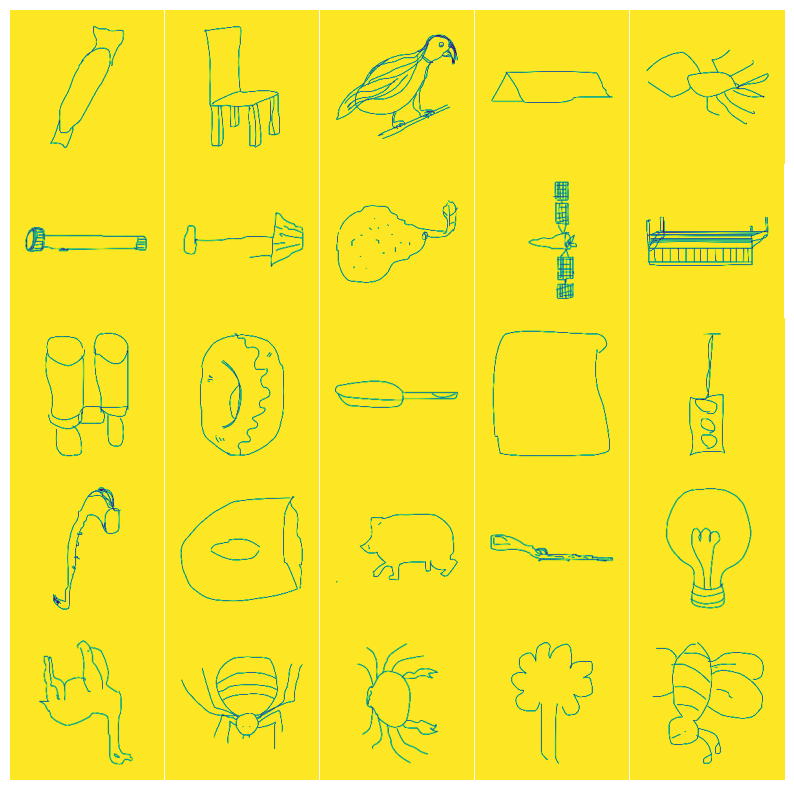

tensor([194,  50, 147, 222, 199,  83,  84, 148, 176,  20,  22,  68,  91,  30,
        230, 178,  63,  15, 171, 121,  40, 199,  60, 232,  17,  87, 204, 150,
          0, 218, 155, 186,   6,  93, 129, 239,  31,  69, 241, 213, 209, 102,
        243,  60,   4,  94, 146, 221, 115, 172, 148,   2, 153, 245, 169,  53,
         74,  30, 220,   7, 122, 147, 178,  16])


In [15]:
images, y = next(iter(train_dataloader))
print(images.shape)

show_aug(images)
print(y)

In [16]:
# check sanity
output = torch.randn(1, 3, 256, 256).to(device)
output.shape

torch.Size([1, 3, 256, 256])

## Step 2: Modelling

### 2.1 Metric and loss

In [17]:
!pip install torchmetrics

Defaulting to user installation because normal site-packages is not writeable


In [18]:
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassF1Score
from torchmetrics import Accuracy, F1Score
from torch.nn import CrossEntropyLoss

# CrossEntropyLoss combines LogSoftmax and NLLLoss
loss = nn.CrossEntropyLoss()

accuracy = Accuracy(task="multiclass", num_classes=N_CLASSES)
f1_score = MulticlassF1Score(num_classes=N_CLASSES)

In [19]:
from tqdm import tqdm

def train_model(model_name, model, train_loader, val_loader, optimizer, lr_scheduler=None, num_epochs=100, num_classes=10):
    print(f"[INFO] Model is initializing... {model_name}")
    
    # Initialize metrics
    criterion = CrossEntropyLoss().to(device)
    accuracy_metric = Accuracy(task="multiclass", num_classes=num_classes).to(device)
    f1_metric = F1Score(task="multiclass", num_classes=num_classes).to(device)
    
    # History tracking
    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }
    
    for epoch in range(num_epochs):
        model.train()
        epoch_losses = []
        epoch_acc = []
        epoch_f1 = []
        
        # Training loop
        for data, target in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            outputs = model(data)
            
            loss = criterion(outputs, target)
            loss.backward()
            optimizer.step()
            
            # Compute metrics
            acc = accuracy_metric(outputs, target)
            f1 = f1_metric(outputs, target)
            
            epoch_losses.append(loss.item())
            epoch_acc.append(acc.item())
            epoch_f1.append(f1.item())
        
        # Validation loop
        model.eval()
        val_losses, val_acc, val_f1 = [], [], []
        
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                
                val_loss = criterion(outputs, target)
                val_acc_batch = accuracy_metric(outputs, target)
                val_f1_batch = f1_metric(outputs, target)
                
                val_losses.append(val_loss.item())
                val_acc.append(val_acc_batch.item())
                val_f1.append(val_f1_batch.item())
        
        # Update learning rate
        if lr_scheduler:
            lr_scheduler.step()
        
        # Update history
        history['train_loss'].append(np.mean(epoch_losses))
        history['train_acc'].append(np.mean(epoch_acc))
        history['train_f1'].append(np.mean(epoch_f1))
        history['val_loss'].append(np.mean(val_losses))
        history['val_acc'].append(np.mean(val_acc))
        history['val_f1'].append(np.mean(val_f1))
        
        print(f"Epoch [{epoch}/{num_epochs}]")
        print(f"Train Loss: {history['train_loss'][-1]:.4f}, Acc: {history['train_acc'][-1]:.4f}, F1: {history['train_f1'][-1]:.4f}")
        print(f"Val Loss: {history['val_loss'][-1]:.4f}, Acc: {history['val_acc'][-1]:.4f}, F1: {history['val_f1'][-1]:.4f}")
    
    return history

In [ ]:
from torchvision.models import mobilenet_v3_large
from torch.optim import Adam

# Load model without pretrained weights
model = mobilenet_v3_large(weights=True)

# Replace classifier
in_features = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(in_features, N_CLASSES)
model.to(device)

optimizer = Adam(model.parameters(), lr=LR)
history = train_model("MobileNet V3", model, train_dataloader, val_dataloader, optimizer, num_epochs=N_EPOCHS, num_classes=N_CLASSES)

/nfs/pic.es/user/y/ycordero/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /nfs/pic.es/user/y/ycordero/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 75.7MB/s]


[INFO] Model is initializing... MobileNet V3


100%|██████████| 248/248 [01:59<00:00,  2.07it/s]


Epoch [0/50]
Train Loss: 3.0801, Acc: 0.3051, F1: 0.3051
Val Loss: 3.3139, Acc: 0.2676, F1: 0.2676


100%|██████████| 248/248 [02:00<00:00,  2.06it/s]


Epoch [1/50]
Train Loss: 1.5919, Acc: 0.5782, F1: 0.5782
Val Loss: 1.9399, Acc: 0.5132, F1: 0.5132


100%|██████████| 248/248 [01:57<00:00,  2.11it/s]


Epoch [2/50]
Train Loss: 1.1576, Acc: 0.6786, F1: 0.6786
Val Loss: 1.6565, Acc: 0.5669, F1: 0.5669


100%|██████████| 248/248 [01:57<00:00,  2.11it/s]


Epoch [3/50]
Train Loss: 0.9192, Acc: 0.7345, F1: 0.7345
Val Loss: 1.8763, Acc: 0.5293, F1: 0.5293


100%|██████████| 248/248 [01:56<00:00,  2.13it/s]


Epoch [4/50]
Train Loss: 0.7227, Acc: 0.7816, F1: 0.7816
Val Loss: 1.6644, Acc: 0.5859, F1: 0.5859


 28%|██▊       | 70/248 [00:33<01:24,  2.11it/s]